In [1]:
from threeML import *
import matplotlib.pyplot as plt
import numpy as np
import math


from astromodels import *
import astropy
import astropy.units as us
from astropy.io import fits
import scipy.optimize as sc
from astromodels.functions.function import Function1D, FunctionMeta, ModelAssertionViolation

[WARNING ] The naima package is not available. Models that depend on it will not be available
[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The ebltable package is not available. Models that depend on it will not be available
[INFO    ] Starting 3ML!
[WARNING ] no display variable set. using backend for graphics without display (agg)
[WARNING ] ROOT minimizer not available
[WARNING ] Multinest minimizer not available
[WARNING ] PyGMO is not available
[WARNING ] The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)
[WARNING ] Could not import plugin FermiLATLike.py. Do you have the relative instrument software installed and configured?
[WARNING ] Could not import plugin HAWCLike.py. Do you have the relative instrument software installed and configured?
[WARNING ] No fermitools installed
[WARNING ] Env. variable OMP_NUM_THREADS is not set.

In [2]:
############
# DATASETS #
############
# SE #
######
crab_SE = OGIPLike("crab_SE",
                   observation='/home/jziegler/cookbook/SPI_cookbook/examples/Crab_TotRev/fit_Crab_SE_02_Rev43-2010/spectra_Crab.fits',
                   response='/home/jziegler/cookbook/SPI_cookbook/examples/Crab_TotRev/fit_Crab_SE_02_Rev43-2010/spectral_response.rmf.fits')

###############
# SE CHANNELS #
###############
crab_SE.set_active_measurements('50 - 510')

#######
# PSD #
#######
crab_PSD = OGIPLike("crab_PSD",
                   observation='/home/jziegler/cookbook/SPI_cookbook/examples/Crab_TotRev/fit_Crab_PSD_02_Rev43-2010/spectra_Crab.fits',
                   response='/home/jziegler/cookbook/SPI_cookbook/examples/Crab_TotRev/fit_Crab_PSD_02_Rev43-2010/spectral_response.rmf.fits')

################
# PSD CHANNELS #
################
crab_PSD.set_active_measurements('510 - 2000')

##################
# PSD EFFICIENCY #
##################
#crab_PSD.fix_effective_area_correction(0.85)
crab_PSD.use_effective_area_correction(0.1, 0.9)

######
# HE #
######
crab_HE = OGIPLike("crab_HE",
                   observation='/home/jziegler/cookbook/SPI_cookbook/examples/Crab_TotRev/fit_Crab_HE_02_Rev43-2010/spectra_Crab.fits',
                   response='/home/jziegler/cookbook/SPI_cookbook/examples/Crab_TotRev/fit_Crab_HE_02_Rev43-2010/spectral_response.rmf.fits')

###############
# HE CHANNELS #
###############
crab_HE.set_active_measurements('2000 - 8000')

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range 50 - 510 translates to channels 11-39
[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observati

In [3]:
####################
#DEFINE FUNCTION # 
####################
def triplebplaw_eval(x, K, xb1, xb2, alpha, beta, gamma):

    n = x.shape[0]
    out = np.empty(n)
    #print(xb1, xb2, alpha, beta, gamma, alpha-beta, beta-gamma)
    factor1 = np.float_power(xb1, alpha - beta)
    factor2 = np.float_power(xb2, beta - gamma)
    
    for idx in range(n):
        if x[idx] < xb1:
            out[idx] = K * np.power(x[idx], alpha)
            
        elif (x[idx] > xb1) & (x[idx] < xb2):
            
            out[idx] = K * factor1 * np.float_power(x[idx], beta)
        
        else:
            
            out[idx] = K * factor1 * factor2 * np.float_power(x[idx], gamma)
            
            
            
    return out

In [4]:

class Triple_Broken_Powerlaw(Function1D, metaclass=FunctionMeta):
        r"""
        description :
            A broken power law function with two break energies
        latex : $ f(x)= K~ \begin{cases} x^{\alpha} & x \le x_{b1} \\ x_{b1}^{\alpha - \beta} x^{\beta} & x_{b1} \le x \le x_{b2} \\x_{b1}^{\alpha - \beta} x_{b2}^{\beta - \gamma} x^{\gamma} & x_{b3} \le x \end{cases} \\ $
        parameters :
            K:
                initial value: 1.0
                desc: Normalization (differential flux at x_b)
                min_value: None
                max_value: None
                unit:
                is_normalization: True
                delta: 0.1
                free: True
            xb1:
                initial value: 10.0
                desc: Break point 1
                min_value: 1.0
                max_value: None
                unit:
                is_normalization: False
                delta: 1.0
                free: True
            xb2:
                initial value: 100.0
                desc: Break point 2
                min_value: 1.0
                max_value: None
                unit:
                is_normalization: False
                delta: 1.0
                free: True
            alpha:
                initial value: -1.5
                desc: Index before the break xb1
                min_value: -10.0
                max_value: 10.0
                unit:
                is_normalization: False
                delta: 0.15000000000000002
                free: True
            beta:
                initial value: -2
                desc: Index after the break xb1 and before break xb2
                min_value: -10.0
                max_value: 10.0
                unit:
                is_normalization: False
                delta: 0.25
                free: True
            gamma:
                initial value: -2.5
                desc: Index after the break xb2
                min_value: -10.0
                max_value: 10.0
                unit:
                is_normalization: False
                delta: 0.25
                free: True
        """


        def _set_units(self, x_unit, y_unit):
            # The indices are always dimensionless
            self.alpha.unit = astropy.units.dimensionless_unscaled
            self.beta.unit = astropy.units.dimensionless_unscaled
            self.gamma.unit = astropy.units.dimensionless_unscaled

            # The break energies have always the same dimension as the x variable
            self.xb1.unit = x_unit
            self.xb2.unit = x_unit

            # The normalization has the same units as the y

            self.K.unit = y_unit


        def evaluate(self, x, K, xb1, xb2, alpha, beta, gamma):

            if isinstance(x, astropy.units.Quantity):
                alpha_ = alpha.value
                beta_ = beta.value
                gamma_ = gamma.value
                K_ = K.value
                xb1_ = xb1.value
                xb2_ = xb2.value
                x_ = x.value

                unit_ = self.y_unit

            else:
                unit_ = 1.0
                alpha_, beta_, gamma_, K_, x_, xb1_, xb2_ = alpha, beta, gamma, K, x, xb1, xb2

            result = triplebplaw_eval(x_, K_, xb1_, xb2_, alpha_, beta_, gamma_)

            return result * unit_



In [5]:
Triple_Broken_Powerlaw()

* description: A broken power law function with two break energies
  * formula: $ f(x)= K~ \begin{cases} x^{\alpha} & x \le x_{b1} \\ x_{b1}^{\alpha - \beta}
    * x^{\beta} & x_{b1} \le x \le x_{b2} \\x_{b1}^{\alpha - \beta} x_{b2}^{\beta - \gamma}
    * x^{\gamma} & x_{b3} \le x \end{cases} \\ $
  * parameters:
    * K:
      * value: 1.0
      * desc: Normalization (differential flux at x_b)
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: true
      * delta: 0.1
      * free: true
    * xb1:
      * value: 10.0
      * desc: Break point 1
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 1.0
      * free: true
    * xb2:
      * value: 100.0
      * desc: Break point 2
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 1.0
      * free: true
    * alpha:
      * value: -1.5
      * desc: Index before the break xb1
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.15000000000000002
      * free: true
    * beta:
      * value: -2.0
      * desc: Index after the break xb1 and before break xb2
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.25
      * free: true
    * gamma:
      * value: -2.5
      * desc: Index after the break xb2
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.25
      * free: true

In [6]:
##################
# SPECTRAL MODEL #
##################
spec = Triple_Broken_Powerlaw()

In [7]:
##############################
# DEFINITION OF POINT SOURCE #
##############################
ps = PointSource('crab',l=0,b=0,spectral_shape=spec)

In [8]:
####################
# MODEL DEFINITION #
####################
ps_model = Model(ps)

In [9]:
####################
# FIXED PARAMETERS #
####################
ps_model.crab.spectrum.main.Triple_Broken_Powerlaw.xb1 = 100
ps_model.crab.spectrum.main.Triple_Broken_Powerlaw.xb1.min_value = 20
ps_model.crab.spectrum.main.Triple_Broken_Powerlaw.xb1.max_value = 10000
ps_model.crab.spectrum.main.Triple_Broken_Powerlaw.xb1.fix = False

ps_model.crab.spectrum.main.Triple_Broken_Powerlaw.xb2 = 500
ps_model.crab.spectrum.main.Triple_Broken_Powerlaw.xb2.min_value = 50
ps_model.crab.spectrum.main.Triple_Broken_Powerlaw.xb2.max_value = 10000
ps_model.crab.spectrum.main.Triple_Broken_Powerlaw.xb2.fix = False

In [10]:
#################
# DISPLAY MODEL #
#################
ps_model.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (6):
--------------------

              value min_value max_value            unit
crab...K        1.0      None      None  keV-1 s-1 cm-2
crab...xb1    100.0      20.0   10000.0             keV
crab...xb2    500.0      50.0   10000.0             keV
crab...alpha   -1.5      None      None                
crab...beta    -2.0      None      None                
crab...gamma   -2.5      None      None                

Fixed parameters (2):
---------------------

                value min_value max_value unit
crab.position.l   0.0       0.0     360.0  deg
crab.position.b   0.0     -90.0      90.0  deg

Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [11]:
###################
# DATA DEFINITION #
###################
ps_data = DataList(crab_SE,crab_PSD,crab_HE)

In [12]:
#####################
# LIKELIHOOD OBJECT #
#####################
ps_jl = JointLikelihood(ps_model, ps_data)

[INFO    ] set the minimizer to minuit


In [13]:
#######
# FIT #
#######
best_fit_parameters_ps, likelihood_values_ps = ps_jl.fit()
#test = ps_jl.fit()


[WARNING ] The current value of the parameter xb1 (10.0) was below the new minimum 20.0.
Best fit values:



,result,unit
parameter,,
crab.spectrum.main.Triple_Broken_Powerlaw.K,1.041 +/- 0.009,1 / (cm2 keV s)
crab.spectrum.main.Triple_Broken_Powerlaw.xb1,(4.58 +/- 0.06) x 10,keV
crab.spectrum.main.Triple_Broken_Powerlaw.xb2,(3.09 +/- 0.07) x 10^2,keV
crab.spectrum.main.Triple_Broken_Powerlaw.alpha,-1.4891 +/- 0.0022,
crab.spectrum.main.Triple_Broken_Powerlaw.beta,-2.1703 +/- 0.0019,
crab.spectrum.main.Triple_Broken_Powerlaw.gamma,-1.861 +/- 0.017,
cons_crab_PSD,(4.67 +/- 0.14) x 10^-1,



Correlation matrix:



1.00,-0.50,-0.01,-0.50,-0.05,0.00,-0.00
-0.50,1.00,-0.01,-0.50,-0.04,0.00,-0.00
-0.01,-0.01,1.00,-0.01,0.20,0.35,0.05
-0.50,-0.50,-0.01,1.00,-0.05,0.00,-0.00
-0.05,-0.04,0.20,-0.05,1.00,-0.08,0.01
0.00,0.00,0.35,0.00,-0.08,1.00,-0.40
-0.00,-0.00,0.05,-0.00,0.01,-0.40,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
crab_HE,16.065592
crab_PSD,24.271589
crab_SE,475.375314
total,515.712495



Values of statistical measures:



,statistical measures
AIC,1047.913879
BIC,1059.217034


In [14]:
####################
# RESTORE BEST FIT #
####################
ps_jl.restore_best_fit()

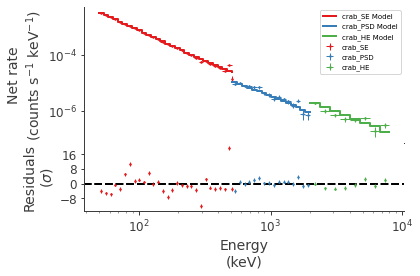

In [15]:
############################################
# PLOT COMBINED SPECTRUM OF DATA AND MODEL #
############################################
plt.figure()
display_spectrum_model_counts(ps_jl,step=True)
#plt.savefig('Crab_spectrum_combined_Rev43-2010_TripleBrokenPowerLaw.pdf')